In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
from tqdm import tqdm
import re
import scipy
import tensorflow
from tensorflow.keras.layers import Input,Flatten, Embedding, Reshape, Multiply, Dropout, Dense, Concatenate, GlobalAveragePooling1D
from tensorflow.keras.layers import Layer, SpatialDropout1D, GlobalMaxPooling1D, Bidirectional, GRU, LSTM
from tensorflow.keras.layers import Dot, TimeDistributed, BatchNormalization, Add, Multiply
from tensorflow.keras import initializers, regularizers, constraints
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
#import keras.backend as K
from sklearn.utils import shuffle
import seaborn as sns
import math
import shap

In [2]:
PATH = "../data/mind_small/"
news = pd.read_csv(PATH + "news.tsv",header=None, sep="\t")
behaviors = pd.read_csv(PATH + "behaviors.tsv", header=None, sep="\t")
news.columns = ["news_id", "category", "sub_category", "title", "abstract", "url", "title_entities", "abstract_entities"]
behaviors.columns = ["idx", "user_id", "time", "history", "impressions"]
behaviors = behaviors.drop_duplicates(["user_id", "history"]) 
behaviors.dropna(subset=["user_id", "history"], inplace=True)

In [3]:
sessions = {}
for idx, row in behaviors.iterrows():
    sessions[row["user_id"]] = row["history"].split(" ")

users = []
clicks = []
for k, v in sessions.items():
    for elem in v:
        users.append(k)
        clicks.append(elem)

tuples = list(zip(users, clicks))
interactions = pd.DataFrame(tuples, columns=["user", "news_id"])
interactions = interactions[:10000]

In [4]:
merged = interactions.merge(news, on=["news_id"])
merged.head()

,user,news_id,category,sub_category,title,abstract,url,title_entities,abstract_entities
0,U13740,N55189,tv,tvnews,"'Wheel Of Fortune' Guest Delivers Hilarious, O...","We'd like to solve the puzzle, Pat: Blair Davi...",https://assets.msn.com/labs/mind/AAIORni.html,[],"[{""Label"": ""Pat Sajak"", ""Type"": ""P"", ""Wikidata..."
1,U10045,N55189,tv,tvnews,"'Wheel Of Fortune' Guest Delivers Hilarious, O...","We'd like to solve the puzzle, Pat: Blair Davi...",https://assets.msn.com/labs/mind/AAIORni.html,[],"[{""Label"": ""Pat Sajak"", ""Type"": ""P"", ""Wikidata..."
2,U85394,N55189,tv,tvnews,"'Wheel Of Fortune' Guest Delivers Hilarious, O...","We'd like to solve the puzzle, Pat: Blair Davi...",https://assets.msn.com/labs/mind/AAIORni.html,[],"[{""Label"": ""Pat Sajak"", ""Type"": ""P"", ""Wikidata..."
3,U78244,N55189,tv,tvnews,"'Wheel Of Fortune' Guest Delivers Hilarious, O...","We'd like to solve the puzzle, Pat: Blair Davi...",https://assets.msn.com/labs/mind/AAIORni.html,[],"[{""Label"": ""Pat Sajak"", ""Type"": ""P"", ""Wikidata..."
4,U27024,N55189,tv,tvnews,"'Wheel Of Fortune' Guest Delivers Hilarious, O...","We'd like to solve the puzzle, Pat: Blair Davi...",https://assets.msn.com/labs/mind/AAIORni.html,[],"[{""Label"": ""Pat Sajak"", ""Type"": ""P"", ""Wikidata..."


# 1. Preprocessing

In [5]:
# remove users which have fewer than 5 interacations
print("Len before removal: ",len(merged))
_keys = merged["user"].value_counts()[merged["user"].value_counts() > 5].keys()
merged = merged[merged["user"].isin(_keys)]
print("Len after removal: ",len(merged))


user_enc = LabelEncoder()
article_enc = LabelEncoder()
merged["user_id"] = user_enc.fit_transform(merged["user"].values)
merged["article_id"] = article_enc.fit_transform(merged["news_id"].values)




Len before removal:  10000
Len after removal:  9867


In [6]:
import nltk
from nltk.corpus import stopwords
# Helper functions
def _removeNonAscii(s):
    return "".join(i for i in s if  ord(i)<128)

def make_lower_case(text):
    return text.lower()

def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

def remove_punctuation(text):
    text = re.sub(r'[^\w\s]', '', text)
    return text

def text_to_list(text):
    text = text.split(" ")
    return text

In [7]:
def clean_title(df):
    df["title_cleaned"] = df.title.apply(func = make_lower_case)
    df["title_cleaned"] = df.title_cleaned.apply(func = remove_stop_words)
    df["title_cleaned"] = df.title_cleaned.apply(func = remove_punctuation)
    return df
def hyphen_to_underline(category):
    """
    Convert hyphen to underline for the subcategories. So that Tfidf works correctly
    """
    return category.replace("-","_")
merged = clean_title(merged)
merged["subcategory_cleaned"] = merged["sub_category"].apply(func = hyphen_to_underline)

In [8]:
vectorizer = TfidfVectorizer(analyzer="word", tokenizer=str.split)
item_ids = merged["article_id"].unique().tolist()
tfidf_matrix = vectorizer.fit_transform(merged["subcategory_cleaned"])
tfidf_feature_names = vectorizer.get_feature_names()
tfidf_matrix

<9867x164 sparse matrix of type '<class 'numpy.float64'>'
	with 9867 stored elements in Compressed Sparse Row format>

In [9]:
item_ids = merged["article_id"].tolist()

def get_item_profile(item_id):
    """
    item_id: the news article id
    Return: an array of each n-gram in the item article. 
        with their n-gram id in tfidf_feature_names and weight.
    """
    idx = item_ids.index(item_id) # returns the index to the item id
    item_profile = tfidf_matrix[idx:idx+1]
    return item_profile
    
def get_item_profiles(ids):
    #print(ids)
    item_profiles_list = [get_item_profile(x) for x in ids]
    item_profiles = scipy.sparse.vstack(item_profiles_list)
    return item_profiles

def build_user_profile(person_id):
    interactions = merged[merged["user_id"] == person_id]["article_id"].values # gets all articles
    user_item_profiles = get_item_profiles(interactions)
    user_item_profiles = np.sum(user_item_profiles, axis=0)
    user_profile_norm = sklearn.preprocessing.normalize(user_item_profiles)
    return user_item_profiles
    
#t = build_user_profile(1)

In [10]:
def calculate_user_profiles(unique_user_ids):
    user_profiles = {}
    for idx in tqdm(unique_user_ids):
        token_relevance = build_user_profile(idx).tolist()[0]
        zipped = zip(tfidf_feature_names, token_relevance)
        s = sorted(zipped, key=lambda x: -x[-1])[:6]
        user_profiles[idx] = s
    return user_profiles
        
user_profiles = calculate_user_profiles(merged["user_id"].unique())


100%|██████████| 231/231 [00:08<00:00, 27.61it/s]


In [11]:
subcategory_to_id = {name: idx+1 for idx, name in enumerate(tfidf_feature_names)}
id_to_subcategory = {idx: name for name, idx in subcategory_to_id.items()}
id_to_subcategory[0] = "Null"
subcategory_to_id["Null"] = 0

In [12]:
# add all id-category to the userprofile in df
profile_array = []
for index, row in tqdm(merged.iterrows()):
    
    user_idx = row["user_id"]
    profile = user_profiles[user_idx]
    temp = []
    for keyword_tuple in profile:
        temp.append(subcategory_to_id[keyword_tuple[0]])
    profile_array.append(temp)
merged["profile"] = profile_array

9867it [00:00, 11602.56it/s]


In [13]:
# add the id-category to the news articles
merged["subcategory_to_int"] = [subcategory_to_id[cat] for cat in merged["subcategory_cleaned"].values]

user_unique = merged.drop_duplicates("user_id")
userid_to_profile = user_unique[["user_id", "profile"]].set_index("user_id").to_dict()["profile"]

category_enc = LabelEncoder()
merged["main_category_int"] = category_enc.fit_transform(merged["category"].values)
article_id_to_category_int = merged[["article_id", "main_category_int"]].set_index("article_id").to_dict()
article_id_to_category_int = article_id_to_category_int["main_category_int"]

article_id_to_subcategory_int = merged[["article_id", "subcategory_to_int"]].set_index("article_id").to_dict()
article_id_to_subcategory_int = article_id_to_subcategory_int["subcategory_to_int"]

# 2. Train test split

In [14]:
def train_test_split(df, user_id, article_id, have_timestamp, timestamp):
    """
    params: 
        col_1: user_id
        col_2: article_id
    """
    df_test = df
    if have_timestamp: # if df have timestamp; take last interacted article into test set
        df_test = df_test.sort_values(timestamp).groupby(user_id).tail(1)
    else:
        df_test = df_test.sort_values(user_id).groupby(user_id).tail(1)
    df_train = df.drop(index=df_test.index)
    
    assert df_test.shape[0] + df_train.shape[0] == df.shape[0]
    
    return df_train, df_test
df_train_true, df_test_true = train_test_split(merged, "user_id", "article_id", False, 0)

In [15]:
def get_userid_to_article_history(df):
    userid_to_article_history = {}
    for user_id in tqdm(df["user_id"].unique()):
        click_history = df[df["user_id"] == user_id]["article_id"].values
        if len(click_history) < 30:
            while len(click_history) < 30:
                click_history = np.append(click_history, 0)
        if len(click_history) > 30:
            click_history = click_history[:30]
        userid_to_article_history[user_id] = click_history
    return userid_to_article_history
userid_to_article_history = get_userid_to_article_history(df_train_true)

100%|██████████| 231/231 [00:00<00:00, 1378.17it/s]


In [16]:
all_article_ids = merged["article_id"].unique()

def negative_sampling(train_df, all_article_ids, user_id, article_id):
    """
    Negative sample training instance; for each positive instance, add 4 negative articles
    
    Return user_ids, news_ids, category_1, category_2, authors_onehotencoded, titles
    """
    
    user_ids, user_click_history, articles, article_category, article_sub_category, labels = [], [], [], [], [], []
    p0, p1, p2, p3, p4, p5, p6, p7, p8, p9 = [], [], [], [], [], [], [], [], [], []
    user_item_set = set(zip(train_df[user_id], 
                            train_df[article_id]))
    num_negatives = 4

    for (u, i) in tqdm(user_item_set):
        user_ids.append(u)
        user_click_history.append(userid_to_article_history[u])
        profile = np.array(userid_to_profile[u])
        p0.append(profile[0])
        p1.append(profile[1])
        p2.append(profile[2])
        p3.append(profile[3])
        p4.append(profile[4])
        p5.append(profile[5])
        article_category.append(article_id_to_category_int[i])
        article_sub_category.append(article_id_to_subcategory_int[i])
        
        articles.append(i)
        labels.append(1)
        for _ in range(num_negatives):
            negative_item = np.random.choice(all_article_ids)
            while (u, negative_item) in user_item_set:
                negative_item = np.random.choice(all_article_ids)
            user_ids.append(u)
            user_click_history.append(userid_to_article_history[u])
            p0.append(profile[0])
            p1.append(profile[1])
            p2.append(profile[2])
            p3.append(profile[3])
            p4.append(profile[4])
            p5.append(profile[5])
            
            article_category.append(article_id_to_category_int[negative_item])
            article_sub_category.append(article_id_to_subcategory_int[negative_item])
            
            articles.append(negative_item)
            labels.append(0)
    
    user_ids, user_click_history, p0, p1, p2, p3, p4, p5, articles,article_category,article_sub_category, labels = shuffle(user_ids,user_click_history, p0, p1, p2, p3, p4, p5, articles,article_category,article_sub_category, labels, random_state=0)

    return pd.DataFrame(list(zip(user_ids,user_click_history,p0, p1, p2, p3, p4, p5, articles,article_category,article_sub_category, labels)), columns=["user_id","user_history","p0", "p1", "p2", "p3", "p4", "p5", "article_id","article_category","article_sub_category", "labels"])



df_train = negative_sampling(df_train_true, all_article_ids, "user_id", "article_id")

100%|██████████| 9500/9500 [00:00<00:00, 27888.75it/s]


In [17]:
def fix_dftrain(df, column, max_len, padding):
    i = 0
    for i in tqdm(range(max_len)):
        df[column + "_" + str(i)] = df[column].apply(lambda x: x[i] if i < len(x) else padding)
    #df.drop(column, axis=1, inplace=True)
    return df

df_train = fix_dftrain(df_train, "user_history", 30, 0)
df_train.drop(columns=["user_history"], inplace=True)
df_train.head()

100%|██████████| 30/30 [00:00<00:00, 42.07it/s]


,user_id,p0,p1,p2,p3,p4,p5,article_id,article_category,article_sub_category,...,user_history_20,user_history_21,user_history_22,user_history_23,user_history_24,user_history_25,user_history_26,user_history_27,user_history_28,user_history_29
0,61,119,123,11,14,45,66,1931,8,119,...,0,0,0,0,0,0,0,0,0,0
1,55,82,45,123,62,74,124,1109,4,161,...,1763,3738,241,3380,3684,3930,1292,2301,1471,2510
2,17,62,147,60,93,39,66,1159,8,118,...,0,0,0,0,0,0,0,0,0,0
3,94,123,89,147,94,113,124,1755,3,122,...,1182,3753,4505,3618,3660,830,3387,515,2175,3380
4,147,113,123,124,74,126,132,2554,8,116,...,2429,2319,3648,3887,1780,4131,3614,1965,1528,1339


In [18]:
# For each user; for each item the user has interacted with in the test set;
    # Sample 99 items the user has not interacted with in the past and add the one test item  
    
def negative_sample_testset(ordiginal_df, df_test, all_article_ids, user_id, article_id):
    test_user_item_set = set(zip(df_test[user_id], df_test[article_id]))
    user_interacted_items = ordiginal_df.groupby(user_id)[article_id].apply(list).to_dict()
    users = []
    p0, p1, p2, p3, p4, p5, p6, p7, p8, p9 = [], [], [], [], [], [], [], [], [], []
    res_arr = []
    article_category, article_sub_category = [], []
    
    userid_to_true_item = {} # keep track of the real items
    for (u,i) in tqdm(test_user_item_set):
        interacted_items = user_interacted_items[u]
        not_interacted_items = set(all_article_ids) - set(interacted_items)
        selected_not_interacted = list(np.random.choice(list(not_interacted_items), 99))
        test_items = selected_not_interacted + [i]
        temp = []
        profile = userid_to_profile[u]
        for j in range(len(test_items)):
            temp.append([u,
                         userid_to_article_history[u], 
                         profile[0],
                         profile[1],
                         profile[2],
                         profile[3],
                         profile[4],
                         profile[5], 
                         test_items[j], article_id_to_category_int[test_items[j]],
                        article_id_to_subcategory_int[test_items[j]]])
        #            user_click_history.append(userid_to_article_history[u])

        res_arr.append(temp)
        userid_to_true_item[u] = i 
    X_test = np.array(res_arr)
    X_test = X_test.reshape(-1, X_test.shape[-1])
    df_test = pd.DataFrame(X_test, columns=["user_id",
                                            "click_history", 
                                            "p0", 
                                            "p1", 
                                            "p2", 
                                            "p3", 
                                            "p4", 
                                            "p5",
                                            "article_id", 
                                            "category", 
                                            "sub_category"])
    return X_test, df_test, userid_to_true_item
X_test, df_test, userid_to_true_item = negative_sample_testset(merged, df_test_true, merged["article_id"].unique(), "user_id", "article_id")
    
    

100%|██████████| 231/231 [00:00<00:00, 763.55it/s]
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [19]:
def fix_dftest(df, column, max_len, padding):
    i = 0
    for i in tqdm(range(max_len)):
        df[column + "_" + str(i)] = df[column].apply(lambda x: x[i] if i < len(x) else padding)
    #df.drop(column, axis=1, inplace=True)
    return df

df_test = fix_dftest(df_test, "click_history", 30, 0)
df_test.drop(columns=["click_history"], inplace=True)

100%|██████████| 30/30 [00:00<00:00, 76.47it/s]


In [20]:
def getHitRatio(ranklist, gtItem):
    for item in ranklist:
        if item == gtItem:
            return 1
    return 0

def getNDCG(ranklist, gtItem):
    for i in range(len(ranklist)):
        item = ranklist[i]
        if item == gtItem:
            return math.log(2) / math.log(i+2)
    return 0

In [21]:
def evaluate_one_rating(model, user_id, user_profiles, all_articles,user_clicks, true_item, categories, sub_categories):
    ### Reshaping to make it on the right shape ###
    #expanded_user_id = np.array([user_id]*100).reshape((100,1))
    all_articles = np.array(all_articles).reshape(-1,1)
    
    # predictions
    #user_history, profile_input, item_input,category_input, subcategory_input
    predictions = model.predict([user_clicks, user_profiles, all_articles, categories, sub_categories]) #TODO: add categories, sub_cat
    predicted_labels = np.squeeze(predictions)
    top_ten_items = [all_articles[i] for i in np.argsort(predicted_labels)[::-1][0:10].tolist()]
    hr = getHitRatio(top_ten_items, true_item)
    ndcg = getNDCG(top_ten_items, true_item)
    return hr, ndcg

def evalaute_model(model, df_test, userid_to_true_item):
    print("Evaluate model")
    hits = []
    ndcgs = []
    users = df_test["user_id"].unique()
    for user_id in tqdm(users):
        user_df = df_test[df_test["user_id"] == user_id] # get the 100 samples for this user
        true_item = userid_to_true_item[user_id] # get the actual true item in the test set
        all_articles = user_df["article_id"].values.astype("int64") # get all possible articles
        user_profiles = user_df.iloc[:, 1:7].values.astype("int64")# get the user_profile
        user_clicks = user_df.iloc[:, 10:].values.astype("int64")
        categories = user_df.iloc[:, 8].values.astype("int64")
        sub_categories = user_df.iloc[:, 9].values.astype("int64")
        
        ht, ndcg = evaluate_one_rating(model, 
                                       user_id, 
                                       user_profiles, 
                                       all_articles,user_clicks, 
                                       true_item, 
                                       categories, 
                                       sub_categories)
        hits.append(ht)
        ndcgs.append(ndcg)
    return hits, ndcgs

In [22]:
def evaluate_one_rating_five(model, user_id, user_profiles, all_articles,user_clicks, true_item, categories, sub_categories):
    ### Reshaping to make it on the right shape ###
    #expanded_user_id = np.array([user_id]*100).reshape((100,1))
    all_articles = np.array(all_articles).reshape(-1,1)
    
    # predictions
    #user_history, profile_input, item_input,category_input, subcategory_input
    predictions = model.predict([user_clicks, user_profiles, all_articles, categories, sub_categories]) #TODO: add categories, sub_cat
    predicted_labels = np.squeeze(predictions)
    top_ten_items = [all_articles[i] for i in np.argsort(predicted_labels)[::-1][0:10].tolist()]
    hr = getHitRatio(top_ten_items[:5], true_item)
    ndcg = getNDCG(top_ten_items[:5], true_item)
    return hr, ndcg

def evalaute_model_five(model, df_test, userid_to_true_item):
    print("Evaluate model")
    hits = []
    ndcgs = []
    users = df_test["user_id"].unique()
    for user_id in tqdm(users):
        user_df = df_test[df_test["user_id"] == user_id] # get the 100 samples for this user
        true_item = userid_to_true_item[user_id] # get the actual true item in the test set
        all_articles = user_df["article_id"].values.astype("int64") # get all possible articles
        user_profiles = user_df.iloc[:, 1:7].values.astype("int64")# get the user_profile
        user_clicks = user_df.iloc[:, 10:].values.astype("int64")
        categories = user_df.iloc[:, 8].values.astype("int64")
        sub_categories = user_df.iloc[:, 9].values.astype("int64")
        
        ht, ndcg = evaluate_one_rating_five(model, 
                                       user_id, 
                                       user_profiles, 
                                       all_articles,user_clicks, 
                                       true_item, 
                                       categories, 
                                       sub_categories)
        hits.append(ht)
        ndcgs.append(ndcg)
    return hits, ndcgs

# 4. Model

In [23]:
# Params
num_unique_categories = len(subcategory_to_id)
num_users = len(merged["user_id"].unique()) +1
num_items = len(merged["article_id"].unique()) + 1
dims = 20
num_sub_categories = len(merged["subcategory_to_int"].unique()) +1
num_categories = len(merged["main_category_int"].unique()) +1

In [24]:
#@tf.autograph.experimental.do_not_convert
def get_model(num_users, num_items, dims,num_categories,num_sub_categories, dense_layers=[128, 64, 32, 8]):
    #User features
    user_history = Input(shape=(30,), name="user")
    user_profile_input = Input(shape=(6,), name="profile")
    #item features
    item_input = Input(shape=(1,), name="item")
    item_category = Input(shape=(1,), name="category")
    item_subcategory = Input(shape=(1,), name="subcategory")
    
    # User emb
    click_history_emb = Embedding(output_dim=dims, input_dim=num_items+1, input_length=30, name="mf_user_emb")(user_history)
    profile_emb = Embedding(output_dim=dims, input_dim=num_unique_categories, input_length=6, name="mf_profile_emb")(user_profile_input)
    
    # Item emb
    item_emb = Embedding(output_dim=dims, input_dim=num_items+1, input_length=1, name="mf_item_emb")(item_input)
    category_emb = Embedding(output_dim=dims, input_dim=num_categories, input_length=1, name="cat_emb")(item_category)
    subcategory_emb = Embedding(output_dim=dims, input_dim=num_sub_categories, input_length=1, name="subcat_emb")(item_subcategory)
    
    lstm_tower = Concatenate(axis=1)([click_history_emb,item_emb])
    mlp_tower = Concatenate(axis=1)([profile_emb,category_emb, subcategory_emb])
    mlp_tower = Flatten()(mlp_tower)
    # Lstm-tower
    lstm_tower = LSTM(40)(lstm_tower)
    lstm_tower = Dropout(0.8)(lstm_tower)
    lstm_tower = BatchNormalization(axis=1)(lstm_tower)
    
    # MLP tower
    mlp_tower = Dense(2)(mlp_tower)
    mlp_tower = Dropout(0.2)(mlp_tower)
    mlp_tower = BatchNormalization(axis=1)(mlp_tower)
    
    # Click predictor
    final = Concatenate()([lstm_tower,mlp_tower ])
    final = BatchNormalization(axis=1)(final)
    y = Dense(1, activation="sigmoid")(final)
    
    
    model = Model(inputs=[user_history, user_profile_input, item_input, item_category, item_subcategory], outputs=y)
    model.compile(
        optimizer=Adam(0.01),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model

model = get_model(num_users, num_items, dims, num_categories,num_sub_categories)

In [25]:
###### Training ########
user_history = df_train.iloc[:, 11:].values.astype("int64")
profile_input = df_train.iloc[:, 1:7].values.astype("int64")
item_input = df_train.iloc[:, 7].values.reshape((-1,1)).astype("int64")
labels = df_train.iloc[:, 10].values.reshape((-1,1)).astype("int64")
category_input = df_train.iloc[:, 8].values.reshape((-1,1)).astype("int64")
subcategory_input = df_train.iloc[:, 9].values.reshape((-1,1)).astype("int64")
print(user_history.shape,profile_input.shape, item_input.shape, labels.shape )

(47500, 30) (47500, 6) (47500, 1) (47500, 1)


In [26]:
all_user_ids = merged["user_id"].unique()

#user_input = df_train.iloc[:, 0].values.reshape((-1,1))
#profile_input = df_train.iloc[:, 1:6].values
#item_input = df_train.iloc[:, 7].values.reshape((-1,1))
#labels = df_train.iloc[:, 8].values.reshape((-1,1))

train_loss = []
val_loss = []
train_acc = []
val_acc = []

hits_list = []
ndcg_list = []
best_hits = 0
best_ndcgs = 0

epochs=2
for epoch in range(epochs):
    hist = model.fit([user_history, profile_input, item_input,category_input, subcategory_input ], labels, epochs=1,validation_split=0.1, shuffle=True, verbose=1)    
    train_loss.append(hist.history["loss"])
    train_acc.append(hist.history["accuracy"])
    val_loss.append(hist.history["val_loss"])
    val_acc.append(hist.history["val_accuracy"])
    
    hits, ndcgs = evalaute_model( model, df_test, userid_to_true_item)
    hits_list.append(np.average(hits))
    ndcg_list.append(np.average(ndcgs))
    
    temp_hits = np.average(hits)
    temp_ndcgs = np.average(ndcgs)
    if (temp_hits > best_hits):
        best_hits = temp_hits
    if temp_ndcgs > best_ndcgs:
        best_ndcgs = temp_ndcgs

1336/1336 [==============================] - 17s 11ms/step - loss: 0.5305 - accuracy: 0.7846 - val_loss: 0.5345 - val_accuracy: 0.8044


  0%|          | 0/231 [00:00<?, ?it/s]

Evaluate model


100%|██████████| 231/231 [00:13<00:00, 17.73it/s]


1336/1336 [==============================] - 15s 11ms/step - loss: 0.4835 - accuracy: 0.8032 - val_loss: 0.5210 - val_accuracy: 0.8023


  1%|          | 2/231 [00:00<00:13, 16.82it/s]

Evaluate model


100%|██████████| 231/231 [00:11<00:00, 20.12it/s]


In [27]:
print("Hit @ 10: {:.2f}".format(best_hits))
print("ncdgs @ 10: {:.2f}".format(best_ndcgs))

Hit @ 10: 0.32
ncdgs @ 10: 0.19


In [28]:
hits_five, ndcgs_five = evalaute_model_five( model, df_test, userid_to_true_item)
print("Hit @ 10: {:.2f}".format(np.average(hits_five)))
print("Hit @ 10: {:.2f}".format(np.average(ndcgs_five)))

  1%|          | 2/231 [00:00<00:15, 14.80it/s]

Evaluate model


100%|██████████| 231/231 [00:12<00:00, 18.11it/s]

Hit @ 10: 0.23
Hit @ 10: 0.16


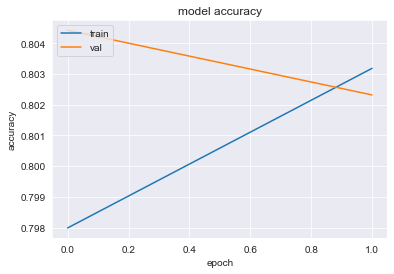

In [36]:
import matplotlib.pyplot as plt
sns.set_style("darkgrid")
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig("architecture4_accuracy.pdf")
plt.show()


In [ ]:
sns.set_style("darkgrid")
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig("architecture4_loss.pdf")
plt.show()

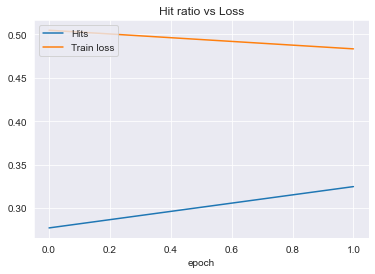

In [37]:
sns.set_style("darkgrid")
plt.plot(hits_list)
plt.plot(train_loss)
plt.title('Hit ratio vs Loss')
plt.xlabel('epoch')
plt.legend(['Hit@10', 'Train loss'], loc='upper left')
plt.savefig("architecture4_hit_loss.pdf")
plt.show()

In [29]:
def get_article_category(article_id):
    return merged[merged["article_id"] == article_id]["subcategory_cleaned"].values[0]
def get_userprofile_to_name(user_id, id_to_subcategory):
    """
    Return array of strings with category names
    """
    arr_profile = get_user_profile(df_train,user_id )
    return [id_to_subcategory[elem] for elem in arr_profile]
def get_user_profile(df, user_id):
    """
    Return the user profile given user_id
    """
    return df[df["user_id"] == user_id].iloc[0, 1:7].values
def get_article_content(article_id):
    article = merged[merged["article_id"] == article_id].head(1)
    title = article["title"].values[0]
    sub_category = article["sub_category"].values[0]
    return title, sub_category

def get_item_features(user_id):
    d = df_test[df_test["user_id"] == user_id]
    return d["category"].values.reshape(-1,1), d["sub_category"].values.reshape(-1,1)

def get_item_features_one_item(article_id):
    d = df_test[df_test["article_id"] == article_id]
    return np.array(d["category"].values[0]), np.array(d["sub_category"].values[0])

In [30]:
def get_article_category(article_id, df):
    """
    Return the article's category
        type: int
    """
    return df[df["article_id"] == article_id]["category"].values[0]
def get_article_subcategory(article_id, df):
    """
    Return the article's category
        type: int
    """
    return df[df["article_id"] == article_id]["sub_category"].values[0]
def get_category_hit_ratio(user_profile, top_ten_categories):
    for profile in user_profile:
        for category in top_ten_categories:
            if profile == category:
                return 1
    return 0
def get_ndcgs_category(user_profile, top_ten_categories):
    for i in range(len(top_ten_categories)):
        item = top_ten_categories[i]
        for profile in user_profile:
            if item == profile:
                return math.log(2) / math.log(i+2)
    return 0

In [31]:
def get_recommendations(user_id, df):
    
    ## Setup ###
    user_profile = get_user_profile(df, user_id)
    click_history = userid_to_article_history[user_id]
    display_items = df[df["user_id"] == user_id]["article_id"].values.reshape(-1, 1).astype("int64")
    user_profile = np.tile(user_profile, display_items.shape[0]).reshape(-1, 6).astype("int64")
    category, sub_category = get_item_features(user_id)
    user_ids = np.tile(np.array(user_id), display_items.shape[0]).reshape(-1,1).astype("int64")
    category = np.asarray(category).astype("int64")
    sub_category = np.asarray(sub_category).astype("int64")
    click_history = np.tile(click_history, display_items.shape[0]).reshape(-1, 30).astype("int64")

    ## Preds ###
    predictions = model.predict([click_history, user_profile, display_items, category, sub_category])
    predicted_labels = np.squeeze(predictions)
    top_ten_items = [display_items[i][0] for i in np.argsort(predicted_labels)[::-1][0:10].tolist()]
    return top_ten_items



In [32]:
def predict_all_users(df):
    hits_ten,ndcgs_ten = [], []
    hits_five, ndcgs_five = [], []

    counter = 0
    for user_id in tqdm(df["user_id"].unique()):
        top_ten_articles = get_recommendations(user_id, df)
        top_ten_subcategories = [get_article_subcategory(_id, df) for _id in top_ten_articles]
        user_profile = get_user_profile(df_test, user_id)

        hit_ten = get_category_hit_ratio(user_profile, top_ten_subcategories)
        ndcg_ten = get_ndcgs_category(user_profile, top_ten_subcategories)
        
        hit_five = get_category_hit_ratio(user_profile, top_ten_subcategories[:5])
        ndcg_five = get_ndcgs_category(user_profile, top_ten_subcategories[:5])
        
        hits_ten.append(hit_ten)
        ndcgs_ten.append(ndcg_ten)
        hits_five.append(hit_five)
        ndcgs_five.append(ndcg_five)
        counter += 1
    return np.average(hits_ten), np.average(ndcgs_ten), np.average(hits_five), np.average(ndcgs_five)
        
        
category_hits_ten, category_ndcg_ten,category_hits_five,category_ndcg_five   = predict_all_users(df_test)

100%|██████████| 231/231 [00:18<00:00, 12.57it/s]


In [33]:
print(category_hits_ten)
print(category_ndcg_ten)
print(category_hits_five)
print(category_ndcg_five)

0.9047619047619048
0.5648207933173073
0.7402597402597403
0.5108100033238899
